# Задание к занятию «Методы декомпозиции»

Преподаватель: Егор Сачко
Описание задания:

Что сделать

Обязательные

1. Провести первичный анализ данных

Посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи.

2. На большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов.

3. На фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в sklearn.decomposition.pca.components_ после построения главных компонент).

4. С отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. 

Метрика оценки качества — ROC AUC.

 

Дополнительные

Поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого используйте все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.

 

Формат сдачи

Ноутбук с кодом/картинками выполненной обязательной части + указание места в leaderboard при решении дополнительной.

 

Дополнительная информация по заданию

Ноубук на Гитхабе.

## Обработка данных

При подготовке признаков будем использовать дополнительные данные:
- справочник MMC кодов https://mcc-codes.ru/ , который позволит получить категории
- курсы валют http://export.rbc.ru/expdocs/free.cb.0.shtml, что позволит перевести валютные операции в рубли, для дальнейшего агрегирования
- ISO справочник валют нужен для объединения исходных данных и курсов валют (https://www.currency-iso.org/en/home/tables/table-a1.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv', dtype={'currency': object, 'MCC': object})
df_test = pd.read_csv('test.csv', dtype={'currency': object, 'MCC': object})
mcc_codes = pd.read_csv('mcc-codes.csv', dtype={'MCC': object })
iso_codes = pd.read_csv('iso_codes.csv', dtype={'Numeric Code': object })
curr_rates = pd.read_csv('curr_rates.csv', dtype={'Numeric Code': object })

In [3]:
y = df_train[['cl_id','target_flag']]
df_train.drop(['target_flag', 'target_sum'], axis=1, inplace=True)
y = y.drop_duplicates()
y = y.set_index('cl_id')
y.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [4]:
y['target_flag'].value_counts()

1    2767
0    2233
Name: target_flag, dtype: int64

Категории более менее сбалансированы, но на кросс валидации будем делать стратифицированное разбиение обучающего набора

In [5]:
df_train['is_test'] = 0
df_test['is_test'] = 1
df_train.shape, df_test.shape, y.shape

((490513, 9), (518376, 9), (5000, 1))

Готовить новые признаки и агреггировать будем сразу для обоих наборов данных

In [6]:
df = pd.concat([df_train, df_test])
df.shape

(1008889, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 518375
Data columns (total 9 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1003825 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 77.0+ MB


В channel_type есть пустые значения. Возможно, один из видов каналов привлечения клиентов просто не заполнен. Заполним пустые значения channel_type константой, которую модель будет трактовать как отдельный канал привлечения

In [8]:
df['channel_type'].value_counts()

type1    619756
type2    357071
type5      9668
type4      9485
type3      7845
Name: channel_type, dtype: int64

In [9]:
df['channel_type'].fillna('NaN', inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 518375
Data columns (total 9 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 77.0+ MB


In [11]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


### Категории MMC

Добавим категории MCC кодов

In [12]:
mcc_codes = mcc_codes[['MCC', 'MCC_group']]
mcc_codes['MCC_group'].value_counts()

Отели и мотели                      304
Авиалинии_авиакомпании              289
Арендаавтомобилей                    92
Различныемагазины                    53
Поставщик услуг                      33
Оптовыепоставщики ипроизводители     31
Бизнес услуги                        25
Развлечения                          22
Розничныемагазины                    21
Профессиональныеуслуги               20
Транспорт                            18
Личные услуги                        17
Ремонтные услуги                     13
Автомобили итранспортныесредства     13
Магазины одежды                      12
Контрактныеуслуги                    11
Государственныеуслуги                11
Продажи по почте/телефону             9
Коммунальные икабельные услуги        8
Членскиеорганизации                   6
Name: MCC_group, dtype: int64

In [13]:
df['MCC'].str.len().value_counts()

4    1008682
3        207
Name: MCC, dtype: int64

In [14]:
mcc_codes['MCC'].str.len().value_counts()

4    1019
Name: MCC, dtype: int64

Перед объединением, трехзначные MCC коды дополним нулем до четырех знаков

In [15]:
df['MCC'] = df['MCC'].str.pad(4, side='left', fillchar='0')

In [16]:
df['MCC'].str.len().value_counts()

4    1008889
Name: MCC, dtype: int64

In [17]:
df = pd.merge(df, mcc_codes, how='left', on='MCC')

In [18]:
df.sample(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group
11560,01/02/2018,228,5814,type4,810,11FEB18:00:00:00,276.00,POS,0,Различныемагазины
163507,01/08/2017,2855,5983,type2,810,05AUG17:00:00:00,2295.75,POS,0,Различныемагазины
867007,01/07/2017,7039,5814,type1,810,30JUL17:00:00:00,626.00,POS,1,Различныемагазины
543202,01/02/2017,974,6011,type2,810,27FEB17:00:00:00,35000.00,WD_ATM_OTHER,1,Поставщик услуг
458625,01/12/2016,9489,4112,type1,810,12DEC16:00:00:00,40.00,POS,0,Транспорт
921520,01/12/2016,8189,5611,type1,810,31DEC16:00:00:00,7785.00,BACK_TRX,1,Магазины одежды
529365,01/06/2017,766,5411,type2,810,18JUN17:00:00:00,878.00,POS,1,Розничныемагазины
857955,01/08/2017,6880,5499,type1,810,21AUG17:00:00:00,331.00,POS,1,Розничныемагазины
815346,01/02/2017,5971,5945,type1,810,19FEB17:00:00:00,299.00,POS,1,Различныемагазины
273798,01/02/2017,5286,5912,type1,810,04FEB17:00:00:00,879.10,POS,0,Различныемагазины


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 10 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008887 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 84.7+ MB


Пустые значения MCC_group заполним константой

In [20]:
df['MCC_group'].fillna('Nan', inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 10 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null object
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008889 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 84.7+ MB


### Курсы валют

Видно, что большинство транзакций не содержат данных о времени проведения операции. Поэтому нет смысла добавлять признаки, связанные с времененем операции. А жаль, можно было бы агрегировать транзакции по времени суток..

In [22]:
df[df['TRDATETIME'].str.contains(':00:00:00') ].shape

(890639, 10)

In [23]:
df['TRDATETIME'] =  pd.to_datetime(df['TRDATETIME'], format='%d%b%y:%H:%M:%S')
df['PERIOD'] =  pd.to_datetime(df['PERIOD'], format='%d/%m/%Y')
df['PERIOD'] = df['PERIOD'].dt.to_period('M')
#df['TRDATETIME'] = df['TRDATETIME'].dt.date

In [24]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group
0,2017-10,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,Розничныемагазины
1,2017-10,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,Поставщик услуг
2,2017-12,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,Различныемагазины
3,2017-10,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,Розничныемагазины
4,2017-10,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,Поставщик услуг


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 10 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null datetime64[ns]
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008889 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 84.7+ MB


Большинство операций в рублях. Для дальнейшего агреггирования по суммам операций добавим курс валюты на день операции (или ближайшего рабочего дня) и добавим новую колонку с суммой валютной операции в рублях.

In [26]:
df['currency'].value_counts().head(10)

810    981731
978     11573
840      3808
933      1460
764       941
203       924
949       902
985       749
826       705
975       596
Name: currency, dtype: int64

In [27]:
df['currency'] = df['currency'].str.pad(3, side='left', fillchar='0')

In [28]:
iso_codes = iso_codes.drop_duplicates()
iso_codes.head()

,Alphabetic Code,Numeric Code
0,AFN,971
1,EUR,978
2,ALL,008
3,DZD,012
4,USD,840


In [29]:
curr_rates = curr_rates[['TICKER','DATE','CLOSE','NOMINAL']]
curr_rates['DATE'] = pd.to_datetime(curr_rates['DATE'])
#curr_rates['DATE'] = curr_rates['DATE'].dt.date
curr_rates.head()

,TICKER,DATE,CLOSE,NOMINAL
0,AMD,2016-10-07,13.1624,100
1,AUD,2016-10-07,47.3852,1
2,AZN,2016-10-07,38.6172,1
3,BGN,2016-10-07,35.7208,1
4,BRL,2016-10-07,19.3728,1


In [30]:
df = pd.merge(df, iso_codes, how='left', left_on='currency', right_on='Numeric Code')
df.drop('Numeric Code', axis=1, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 11 columns):
PERIOD             1008889 non-null object
cl_id              1008889 non-null int64
MCC                1008889 non-null object
channel_type       1008889 non-null object
currency           1008889 non-null object
TRDATETIME         1008889 non-null datetime64[ns]
amount             1008889 non-null float64
trx_category       1008889 non-null object
is_test            1008889 non-null int64
MCC_group          1008889 non-null object
Alphabetic Code    1008836 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 92.4+ MB


In [32]:
df.rename(columns={'Alphabetic Code': 'curr_code'}, inplace=True)
df.sample(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code
136205,2016-12,2430,5541,type2,810,2016-12-31 00:00:00,1476.0,POS,0,Автомобили итранспортныесредства,RUB
734811,2017-06,4278,6011,type1,810,2017-06-02 09:39:11,50000.0,WD_ATM_ROS,1,Поставщик услуг,RUB
212710,2017-03,3816,5411,type1,810,2017-03-25 00:00:00,499.0,POS,0,Розничныемагазины,RUB
567916,2017-08,1358,4814,type2,810,2017-08-28 13:32:05,500.0,CAT,1,Коммунальные икабельные услуги,RUB
286200,2017-05,5518,5309,type1,810,2017-05-14 00:00:00,2350.0,POS,0,Розничныемагазины,RUB
292239,2016-10,5644,5722,type1,810,2016-10-22 00:00:00,5180.0,POS,0,Различныемагазины,RUB
139049,2017-09,2474,4121,type2,810,2017-09-04 00:00:00,361.0,POS,0,Транспорт,RUB
454266,2016-12,9387,5411,type1,810,2016-12-23 00:00:00,153.8,POS,0,Розничныемагазины,RUB
696900,2017-04,3547,5411,type1,810,2017-04-03 00:00:00,1136.0,POS,1,Розничныемагазины,RUB
304382,2017-04,5916,5411,type1,810,2017-04-28 00:00:00,84.0,POS,0,Розничныемагазины,RUB


In [33]:
curr_rates.rename(columns={'TICKER': 'curr_code', 'DATE': 'TRDATETIME', 'CLOSE': 'exch_rate', 'NOMINAL': 'exch_nominal'}, inplace=True)
curr_rates.head()

,curr_code,TRDATETIME,exch_rate,exch_nominal
0,AMD,2016-10-07,13.1624,100
1,AUD,2016-10-07,47.3852,1
2,AZN,2016-10-07,38.6172,1
3,BGN,2016-10-07,35.7208,1
4,BRL,2016-10-07,19.3728,1


In [34]:
df = pd.merge_asof(df.sort_values(by=['TRDATETIME']), curr_rates.sort_values(by=['TRDATETIME']), on='TRDATETIME', by='curr_code', tolerance=pd.Timedelta('10d'))
df.loc[df['currency'] == '810', 'exch_rate'] = 1
df.loc[df['currency'] == '810', 'exch_nominal'] = 1


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008889 entries, 0 to 1008888
Data columns (total 13 columns):
PERIOD          1008889 non-null object
cl_id           1008889 non-null int64
MCC             1008889 non-null object
channel_type    1008889 non-null object
currency        1008889 non-null object
TRDATETIME      1008889 non-null datetime64[ns]
amount          1008889 non-null float64
trx_category    1008889 non-null object
is_test         1008889 non-null int64
MCC_group       1008889 non-null object
curr_code       1008836 non-null object
exch_rate       1005519 non-null float64
exch_nominal    1005519 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 107.8+ MB


Для валюты у трех тысяч операций не нашлось курса. При агрегировании в рублях будем считать эти операции нулевыми. Можно было бы заморочиться дальше и использовать дополнительные кросс курсы в евро или долларах.

In [36]:
df['exch_rate'].fillna(0, inplace=True)
df['exch_nominal'].fillna(1, inplace=True)

In [37]:
df['amount_rub'] = df['amount'] / df['exch_nominal'] * df['exch_rate']

In [38]:
df[df['currency'] != '810'].sample(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub
823627,2017-08,928,5411,type2,978,2017-08-07,12.9,POS,1,Розничныемагазины,EUR,71.6879,1.0,924.77391
515449,2017-05,4570,7230,type1,203,2017-05-12,726.0,POS,0,Личные услуги,CZK,23.3948,10.0,1698.46248
946794,2017-09,1933,5812,type2,949,2017-09-28,20.0,POS,0,Различныемагазины,TRY,16.2662,1.0,325.32400
681368,2017-06,1139,5977,type2,978,2017-06-29,47.1,POS,0,Различныемагазины,EUR,67.6868,1.0,3188.04828
129332,2016-12,1124,5699,type2,203,2016-12-27,897.0,POS,1,Магазины одежды,CZK,23.5550,10.0,2112.88350
978829,2017-11,6065,5993,type1,978,2017-11-16,4.6,POS,0,Различныемагазины,EUR,71.1721,1.0,327.39166
842825,2017-08,2752,5411,type2,978,2017-08-13,10.4,POS,0,Розничныемагазины,EUR,70.7502,1.0,735.80208
155625,2017-01,5413,6011,type1,978,2017-01-04,150.0,WD_ATM_OTHER,1,Поставщик услуг,EUR,63.8111,1.0,9571.66500
13875,2016-11,9686,5945,type1,203,2016-11-07,966.0,POS,1,Различныемагазины,CZK,26.0948,10.0,2520.75768
654349,2017-06,10026,5814,type1,840,2017-06-22,27.7,POS,1,Различныемагазины,USD,60.0000,1.0,1662.00000


### Дни недели и выходные

По времени транзакции вычисляем и добавляем день недели и признак того, что это выходной день

In [39]:
df['dayofweek'] = df['TRDATETIME'].dt.dayofweek.astype('object')
df['is_weekend'] = (df['dayofweek'] >= 5).astype('int64')

In [40]:
df.sample(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend
562300,2017-05,4404,5411,type1,810,2017-05-27 00:00:00,1751.00,POS,1,Розничныемагазины,RUB,1.0,1.0,1751.00,5,1
105362,2016-12,6505,5912,type1,810,2016-12-20 00:00:00,3719.83,POS,1,Различныемагазины,RUB,1.0,1.0,3719.83,1,0
977345,2017-11,574,6011,type2,810,2017-11-11 12:44:13,12000.00,WD_ATM_ROS,0,Поставщик услуг,RUB,1.0,1.0,12000.00,5,1
48833,2016-11,6285,5261,type1,810,2016-11-29 00:00:00,912.00,POS,0,Розничныемагазины,RUB,1.0,1.0,912.00,1,0
691713,2017-07,8913,5641,type1,810,2017-07-02 00:00:00,1305.83,POS,0,Магазины одежды,RUB,1.0,1.0,1305.83,6,1


### Пополнение баланса

Далее, по категориям транзакций добавляем признак пополнения баланса

In [41]:
in_category = ['C2C_IN', 'DEPOSIT']
out_category = ['POS', ' C2C_OUT', 'WD_ATM_PARTNER']

In [42]:
#df['in'] = df['trx_category'].isin(in_category).astype('object')
df['is_withdrawal'] = df['trx_category'].isin(out_category).astype('object')

In [43]:
df.sample(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend,is_withdrawal
889047,2017-08,9973,5814,type1,810,2017-08-29 00:00:00,78.0,POS,0,Различныемагазины,RUB,1.0,1.0,78.0,1,0,True
735626,2017-07,8407,5814,type1,810,2017-07-14 00:00:00,105.0,POS,0,Различныемагазины,RUB,1.0,1.0,105.0,4,0,True
450409,2017-04,1482,6011,type2,810,2017-04-21 11:12:12,5000.0,DEPOSIT,0,Поставщик услуг,RUB,1.0,1.0,5000.0,4,0,False
846059,2017-08,4893,5814,type1,810,2017-08-14 00:00:00,69.0,POS,1,Различныемагазины,RUB,1.0,1.0,69.0,0,0,True
499299,2017-05,5558,5814,type1,810,2017-05-07 00:00:00,563.0,POS,0,Различныемагазины,RUB,1.0,1.0,563.0,6,1,True


## Анализ данных

Рассмотрим данные в обучающем наборе

In [164]:
#df.describe(include='all').T

In [165]:
df_train = df[df['is_test']==0]
df_train.shape

(490513, 17)

In [166]:
df_train = df_train.join(y, how='left', on='cl_id')
df_train.shape

(490513, 18)

In [167]:
df_train1 = df_train[df_train['target_flag']==1]
df_train0 = df_train[df_train['target_flag']==0]
df_train1.shape, df_train0.shape

((320103, 18), (170410, 18))

Общее количество операций у клиентов, которые продолжили пользоваться продуктом, в два раза больше

### Данные по клиентам

In [168]:
df1 = df_train1.groupby(['cl_id'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0.groupby(['cl_id'])['amount_rub'].agg(['mean', 'sum', 'count'])

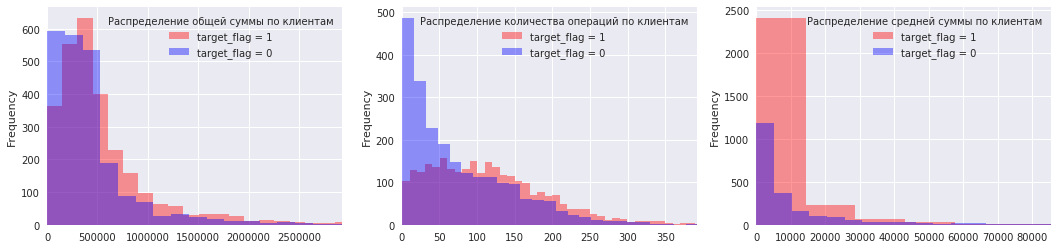

In [169]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
df1['sum'].plot.hist(bins=50, alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.hist(bins=50, alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.set_xlim(0,df0['sum'].max()/3)
ax1.legend(title='Распределение общей суммы по клиентам')

df1['count'].plot.hist(bins=50, alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.hist(bins=50, alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.set_xlim(0,df0['count'].max()/2)
ax2.legend(title='Распределение количества операций по клиентам')

df1['mean'].plot.hist(bins=50, alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.hist(bins=50, alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.set_xlim(0,df0['mean'].max()/3)
ax3.legend(title='Распределение средней суммы по клиентам')

Клиенты, которые ушли, были менее активны по количеству операций и с меньшей средней суммой

### Канал привлечения

In [170]:
df1 = df_train1.groupby(['channel_type'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['channel_type'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['channel_type'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['channel_type'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']
#df1 = df1.divide(df1_cli['nunique'], axis=0)
#df0 = df0.divide(df0_cli['nunique'], axis=0)

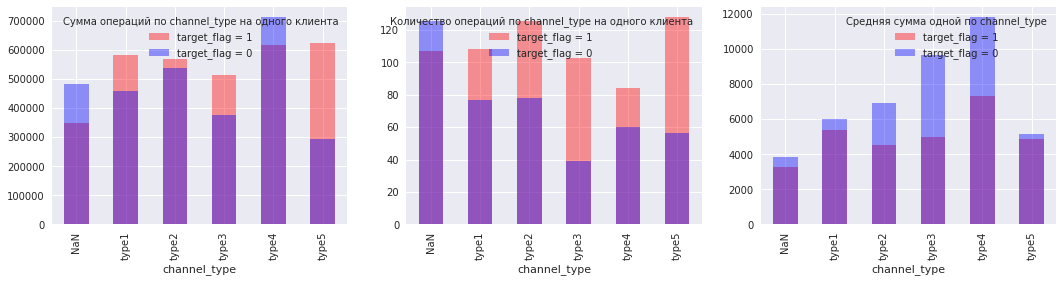

In [171]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма операций по channel_type на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по channel_type на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной по channel_type')

### MCC коды

In [172]:
df1 = df_train1.groupby(['MCC'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['MCC'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['MCC'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['MCC'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

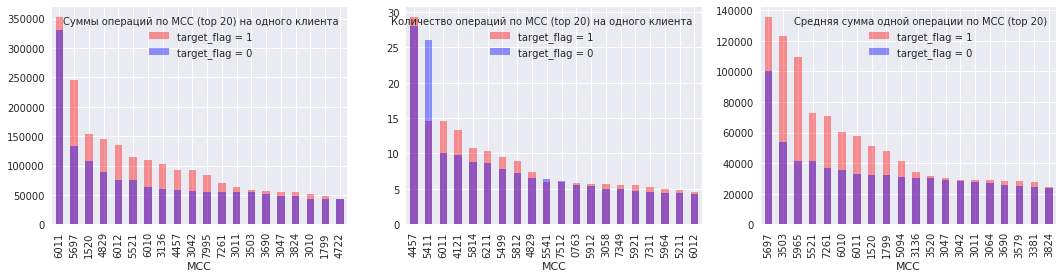

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1.nlargest(20, 'sum')['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0.nlargest(20, 'sum')['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по MCC (top 20) на одного клиента')

df1.nlargest(20, 'count')['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0.nlargest(20, 'count')['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по MCC (top 20) на одного клиента')

df1.nlargest(20, 'mean')['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0.nlargest(20, 'mean')['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции по MCC (top 20)')

По суммам операций клиенты больше всего просто снимали наличные (6011), по количеству операций больше всего платили в супермаркетах (5411)

### Группы MCC кодов

In [174]:
df1 = df_train1.groupby(['MCC_group'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['MCC_group'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['MCC_group'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['MCC_group'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

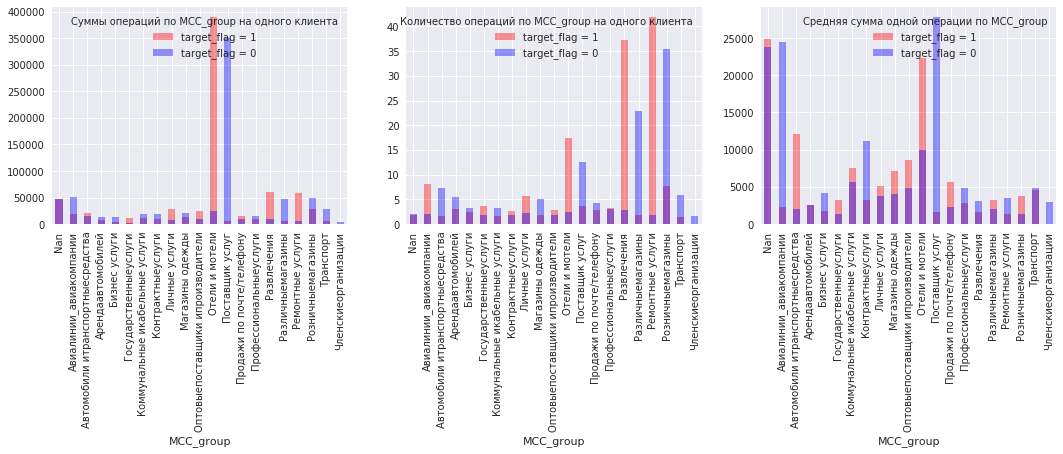

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по MCC_group на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по MCC_group на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции по MCC_group')

### Категории транзакций

In [176]:
df1 = df_train1.groupby(['trx_category'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['trx_category'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['trx_category'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['trx_category'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

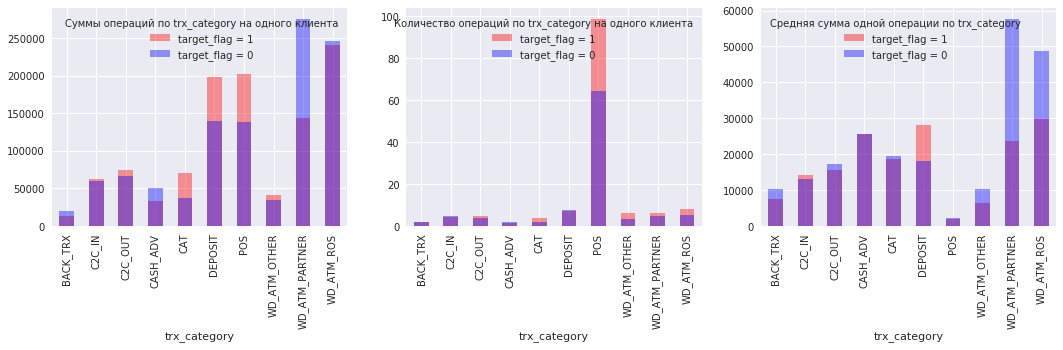

In [177]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по trx_category на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по trx_category на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции по trx_category')

Ожидаемо, клиенты, которые ушли, по средней сумме больше выводили денежные средства

### Дни недели

In [178]:
df1 = df_train1.groupby(['dayofweek'])['amount_rub'].agg(['mean','sum', 'count'])
df0 = df_train0.groupby(['dayofweek'])['amount_rub'].agg(['mean','sum', 'count'])
df1_cli = df_train1.groupby(['dayofweek'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['dayofweek'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']


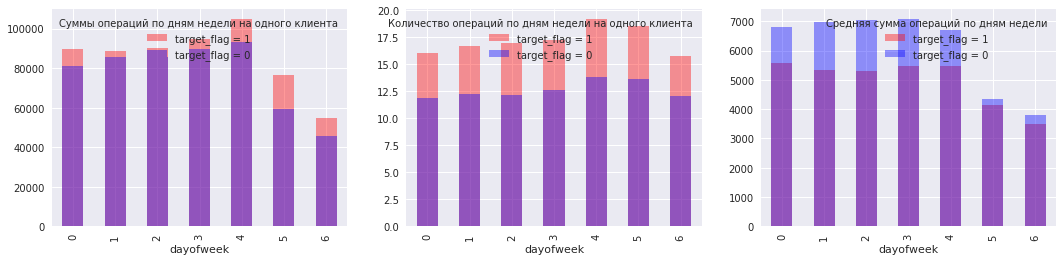

In [179]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Суммы операций по дням недели на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций по дням недели на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма операций по дням недели')

Количество и сумма по операциям в пятницу больше, чем в остальные дни. Но странно, что средний размер суммы у клиентов, которые ушли, почему-то выше..

### Данные по периодам

In [180]:
df1 = df_train1.groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0.groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df1_cli = df_train1.groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df0_cli = df_train0.groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

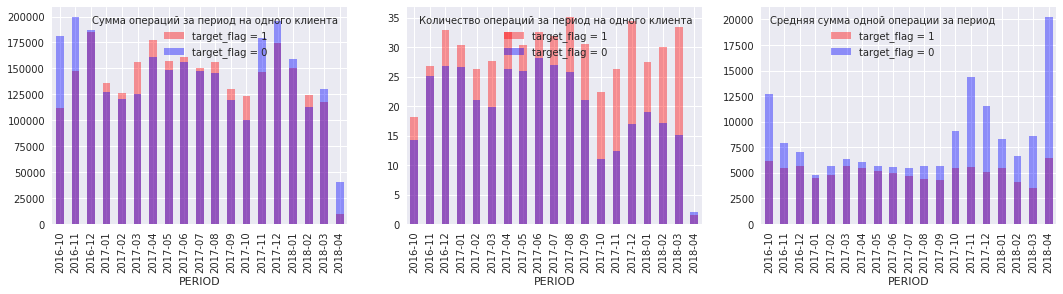

In [181]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма операций за период на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество операций за период на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции за период')

В первых начальных периодах активность клиентов обеих категорий примерно одинакова. Дальше, клиенты, которые ушли, былии меннее активны. Но средяя сумма операции у этих клиентов все равно выше. Видимо, к этой категории относятся более состоятельные клиенты

In [182]:
df1 = df_train1[df_train1['is_withdrawal']==True].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0[df_train0['is_withdrawal']==True].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df1_cli = df_train1[df_train1['is_withdrawal']==True].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df0_cli = df_train0[df_train0['is_withdrawal']==True].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

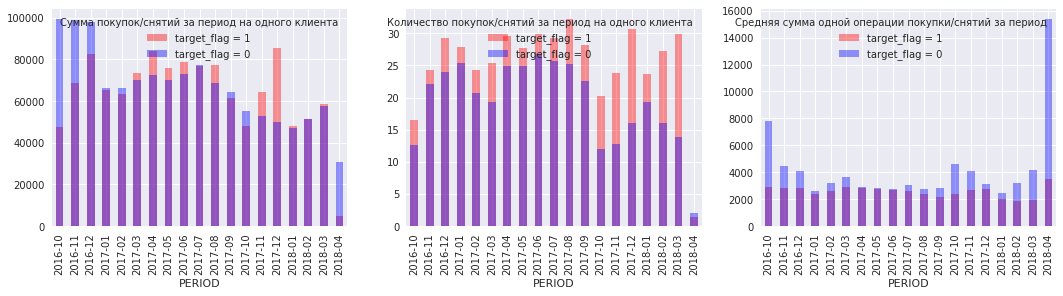

In [183]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма покупок/снятий за период на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество покупок/снятий за период на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции покупки/снятий за период')

In [184]:
df1 = df_train1[df_train1['is_withdrawal']==False].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df0 = df_train0[df_train0['is_withdrawal']==False].groupby(['PERIOD'])['amount_rub'].agg(['mean', 'sum', 'count'])
df1_cli = df_train1[df_train1['is_withdrawal']==False].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df0_cli = df_train0[df_train0['is_withdrawal']==False].groupby(['PERIOD'])['cl_id'].agg(['nunique'])
df1['sum'] = df1['sum'] / df1_cli['nunique']
df0['sum'] = df0['sum'] / df0_cli['nunique']
df1['count'] = df1['count'] / df1_cli['nunique']
df0['count'] = df0['count'] / df0_cli['nunique']

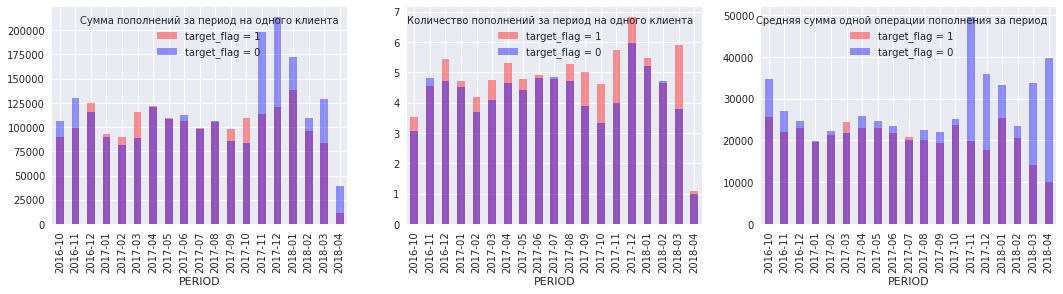

In [185]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

df1['sum'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax1)
df0['sum'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax1)
ax1.legend(title='Сумма пополнений за период на одного клиента')

df1['count'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax2)
df0['count'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax2)
ax2.legend(title='Количество пополнений за период на одного клиента')

df1['mean'].plot.bar(alpha=0.4, label='target_flag = 1', color='r', ax=ax3)
df0['mean'].plot.bar(alpha=0.4, label='target_flag = 0', color='b', ax=ax3)
ax3.legend(title='Средняя сумма одной операции пополнения за период')

Активность пополнений всех клиентов во второй половине периодов снизилась. Средний размер пополнений у ушедших клиентов был выше. Скорее всего продукт был кредитной картой, эти клиенты делали пополнения перед закрытием

## Признаки

In [186]:
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend,is_withdrawal
0,2016-10,1290,5411,type2,810,2016-10-07,2465.00,POS,0,Розничныемагазины,RUB,1.0,1.0,2465.00,4,0,True
1,2016-10,7689,5921,type1,810,2016-10-07,119.78,POS,1,Различныемагазины,RUB,1.0,1.0,119.78,4,0,True
2,2016-10,7689,5411,type1,810,2016-10-07,2678.00,POS,1,Розничныемагазины,RUB,1.0,1.0,2678.00,4,0,True
3,2016-10,485,6011,type2,810,2016-10-07,3600.00,WD_ATM_PARTNER,0,Поставщик услуг,RUB,1.0,1.0,3600.00,4,0,True
4,2016-10,485,4121,type2,810,2016-10-07,242.00,POS,0,Транспорт,RUB,1.0,1.0,242.00,4,0,True


In [187]:
df.shape

(1008889, 17)

In [188]:
X_full = df.groupby(['cl_id', 'channel_type', 'is_test'])['amount_rub'].agg(['sum','count','mean']).sort_index()

In [189]:
X_full = X_full.reset_index().set_index('cl_id')

In [190]:
X_full.shape

(10217, 5)

In [191]:
X_full = pd.get_dummies(X_full)
X_full.head()

,is_test,sum,count,mean,channel_type_NaN,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
cl_id,,,,,,,,,,
0,0,64383.000000,5,12876.600000,1,0,0,0,0,0
1,0,327185.976007,104,3146.019000,1,0,0,0,0,0
2,1,328717.720000,199,1651.847839,1,0,0,0,0,0
3,1,270046.090000,96,2812.980104,1,0,0,0,0,0
4,1,351133.982477,158,2222.366978,1,0,0,0,0,0


In [192]:
df_temp = df.groupby(['cl_id', 'MCC'])['amount_rub'].agg(['sum']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.shape

(10217, 384)

In [193]:
df_temp.head()

,sum_0742,sum_0763,sum_0780,sum_1520,sum_1711,sum_1731,sum_1740,sum_1750,sum_1761,sum_1799,...,sum_8699,sum_8911,sum_8931,sum_8999,sum_9211,sum_9222,sum_9311,sum_9399,sum_9402,sum_9405
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7844.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7811.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='mcc')
X_full.shape

(10217, 394)

In [195]:
#X_full.isnull().values.any()

In [196]:
df_temp = df.groupby(['cl_id', 'currency'])['amount'].agg(['sum']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_032,sum_036,sum_044,sum_048,sum_051,sum_124,sum_144,sum_156,sum_170,sum_188,...,sum_944,sum_946,sum_949,sum_975,sum_977,sum_978,sum_980,sum_981,sum_985,sum_986
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,884.91,0.0,0.00,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,802.68,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,186.23,0.0,0.00,0.0,0.0


In [197]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='curr')
X_full.shape

(10217, 461)

In [198]:
#X_full.isnull().values.any()

In [199]:
df_temp = df.groupby(['cl_id', 'trx_category'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_BACK_TRX,sum_C2C_IN,sum_C2C_OUT,sum_CASH_ADV,sum_CAT,sum_DEPOSIT,sum_POS,sum_WD_ATM_OTHER,sum_WD_ATM_PARTNER,sum_WD_ATM_ROS,...,mean_BACK_TRX,mean_C2C_IN,mean_C2C_OUT,mean_CASH_ADV,mean_CAT,mean_DEPOSIT,mean_POS,mean_WD_ATM_OTHER,mean_WD_ATM_PARTNER,mean_WD_ATM_ROS
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,36562.0,0.0,0.0,20000.0,7821.000000,0.0,0.0,0.0,...,0.0,0.0,36562.0,0.0,0.0,20000.0,2607.000000,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,95000.0,182185.976007,0.0,0.0,50000.0,...,0.0,0.0,0.0,0.0,0.0,47500.0,1803.821545,0.0,0.000000,50000.000000
2,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.720000,0.0,78500.0,55400.0,...,2220.0,300.0,1000.0,0.0,0.0,0.0,1080.444114,0.0,7136.363636,6155.555556
3,0.0,75000.0,35000.0,0.0,0.0,0.0,115646.090000,9500.0,0.0,34900.0,...,0.0,37500.0,17500.0,0.0,0.0,0.0,1482.642179,2375.0,0.000000,3490.000000
4,0.0,0.0,1150.0,0.0,0.0,0.0,298183.982477,0.0,30500.0,21300.0,...,0.0,0.0,575.0,0.0,0.0,0.0,2042.356044,0.0,5083.333333,5325.000000


In [200]:
X_full = X_full.join(df_temp, how='left', on='cl_id')
X_full.shape

(10217, 491)

In [201]:
#X_full.isnull().values.any()

In [202]:
df_temp = df.groupby(['cl_id', 'MCC_group'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_Nan,sum_Авиалинии_авиакомпании,sum_Автомобили итранспортныесредства,sum_Арендаавтомобилей,sum_Бизнес услуги,sum_Государственныеуслуги,sum_Коммунальные икабельные услуги,sum_Контрактныеуслуги,sum_Личные услуги,sum_Магазины одежды,...,mean_Отели и мотели,mean_Поставщик услуг,mean_Продажи по почте/телефону,mean_Профессиональныеуслуги,mean_Развлечения,mean_Различныемагазины,mean_Ремонтные услуги,mean_Розничныемагазины,mean_Транспорт,mean_Членскиеорганизации
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,...,0.0,28281.000000,0.0,0.0,0.000000,767.000000,0.0,3527.000000,0.000000,0.0
1,0.0,0.0,0.00,0.0,2037.228,210.0,0.0,0.0,0.0,10586.019844,...,0.0,36455.344900,0.0,0.0,2031.613483,1861.809015,0.0,1500.711419,1752.182665,0.0
2,0.0,6000.0,307.90,0.0,7844.000,0.0,11429.0,0.0,15334.0,35165.000000,...,975.0,6008.695652,0.0,0.0,995.000000,858.360536,0.0,292.648889,695.542857,0.0
3,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,911.4,45053.730000,...,0.0,8577.777778,0.0,0.0,0.000000,998.258980,0.0,1098.174615,2163.333333,0.0
4,0.0,0.0,6007.94,0.0,8111.000,0.0,749.0,0.0,0.0,7072.500000,...,0.0,4412.500000,0.0,3000.0,3350.000000,858.079740,0.0,6753.349615,0.000000,0.0


In [203]:
X_full = X_full.join(df_temp, how='left', on='cl_id')
X_full.shape

(10217, 554)

In [204]:
#X_full.isnull().values.any()

In [205]:
df_temp = df.groupby(['cl_id', 'dayofweek'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_0,sum_1,sum_2,sum_3,sum_4,sum_5,sum_6,count_0,count_1,count_2,...,count_4,count_5,count_6,mean_0,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.00000,37329.000000,0.00000,20000.000000,0.000000,7054.000000,0.0000,0,2,0,...,0,2,0,0.000000,18664.500000,0.000000,20000.000000,0.000000,3527.000000,0.000000
1,23183.66944,71007.367213,8965.73065,13704.280704,20570.289743,82352.388557,107402.2497,20,20,16,...,10,15,7,1159.183472,3550.368361,560.358166,856.517544,2057.028974,5490.159237,15343.178529
2,44580.21000,82033.300000,39448.36000,44534.750000,58713.000000,32823.400000,26584.7000,32,41,29,...,37,15,8,1393.131562,2000.812195,1360.288276,1203.641892,1586.837838,2188.226667,3323.087500
3,46694.00000,18736.790000,30971.19000,46386.380000,82359.000000,30807.000000,14091.7300,17,14,16,...,15,9,8,2746.705882,1338.342143,1935.699375,2728.610588,5490.600000,3423.000000,1761.466250
4,21565.00000,28364.580000,6272.98000,27184.602477,151919.500000,84055.110000,31772.2100,17,8,12,...,28,49,22,1268.529412,3545.572500,522.748333,1235.663749,5425.696429,1715.410408,1444.191364


In [206]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='dayofweek')
X_full.shape

(10217, 575)

In [207]:
#X_full.isnull().values.any()

In [208]:
df_temp = df.groupby(['cl_id', 'is_weekend'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_0,sum_1,count_0,count_1,mean_0,mean_1
cl_id,,,,,,
0,57329.000000,7054.000000,3,2,19109.666667,3527.000000
1,137431.337750,189754.638257,82,22,1675.991924,8625.210830
2,269309.620000,59408.100000,176,23,1530.168295,2582.960870
3,225147.360000,44898.730000,79,17,2849.966582,2641.101765
4,235306.662477,115827.320000,87,71,2704.674281,1631.370704


In [209]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='weekend')
X_full.shape

(10217, 581)

In [210]:
#X_full.isnull().values.any()

In [211]:
df_temp = df.groupby(['cl_id', 'PERIOD'])['amount_rub'].agg(['sum','count','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_2016-10,sum_2016-11,sum_2016-12,sum_2017-01,sum_2017-02,sum_2017-03,sum_2017-04,sum_2017-05,sum_2017-06,sum_2017-07,...,mean_2017-07,mean_2017-08,mean_2017-09,mean_2017-10,mean_2017-11,mean_2017-12,mean_2018-01,mean_2018-02,mean_2018-03,mean_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,15904.00000,0.0,767.0,0.00,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,53930.26,...,4902.750909,543.928571,3857.422657,1262.00047,0.0,0.0,0.00,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,77439.16,95631.96,137492.8,18153.8,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1000.0,85964.94,113730.00,...,2369.375000,3650.060526,0.000000,0.00000,0.0,0.0,0.00,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,104.99,1580.436867,3001.420993,749.0


In [212]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='period')
X_full.shape

(10217, 638)

In [213]:
#X_full.isnull().values.any()

In [214]:
df_temp = df[df['is_withdrawal']==True].groupby(['cl_id', 'PERIOD'])['amount_rub'].agg(['sum','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_2016-10,sum_2016-11,sum_2016-12,sum_2017-01,sum_2017-02,sum_2017-03,sum_2017-04,sum_2017-05,sum_2017-06,sum_2017-07,...,mean_2017-07,mean_2017-08,mean_2017-09,mean_2017-10,mean_2017-11,mean_2017-12,mean_2018-01,mean_2018-02,mean_2018-03,mean_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,3527.00000,0.0,767.0,0.00,0.00000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,3930.26,...,393.026000,543.928571,2402.670079,1262.00047,0.0,0.0,0.00,0.00000,0.000000,0.0
2,0.0,0.0,0.0,0.0,47239.16,65691.96,136492.8,18153.8,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00,0.00000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,49964.94,44330.00,...,1081.219512,1334.446875,0.000000,0.00000,0.0,0.0,0.00,0.00000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,104.99,1508.45325,2959.339035,749.0


In [215]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='period_out')
X_full.shape

(10217, 676)

In [216]:
#X_full.isnull().values.any()

In [217]:
df_temp = df[df['is_withdrawal']==False].groupby(['cl_id', 'PERIOD'])['amount_rub'].agg(['sum','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_2016-10,sum_2016-11,sum_2016-12,sum_2017-01,sum_2017-02,sum_2017-03,sum_2017-04,sum_2017-05,sum_2017-06,sum_2017-07,...,mean_2017-07,mean_2017-08,mean_2017-09,mean_2017-10,mean_2017-11,mean_2017-12,mean_2018-01,mean_2018-02,mean_2018-03,mean_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,28281.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,...,50000.000000,0.0,47500.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,30200.0,29940.0,1000.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,36000.0,69400.0,...,9914.285714,16000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3500.0,3983.333333,0.0


In [218]:
#df_temp.isnull().values.any()

In [219]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='period_in')
X_full.shape

(10217, 714)

In [220]:
df_temp = df.groupby(['cl_id', 'PERIOD','trx_category'])['amount_rub'].agg(['sum','mean']).unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

sum_BACK_TRX  sum_C2C_IN  sum_C2C_OUT  sum_CASH_ADV  sum_CAT  \
cl_id PERIOD                                                                  
0     2017-10           0.0         0.0      36562.0           0.0      0.0   
      2017-12           0.0         0.0          0.0           0.0      0.0   
1     2017-07           0.0         0.0          0.0           0.0      0.0   
      2017-08           0.0         0.0          0.0           0.0      0.0   
      2017-09           0.0         0.0          0.0           0.0      0.0   

               sum_DEPOSIT        sum_POS  sum_WD_ATM_OTHER  \
cl_id PERIOD                                                  
0     2017-10      20000.0    7054.000000               0.0   
      2017-12          0.0     767.000000               0.0   
1     2017-07          0.0    3930.260000               0.0   
      2017-08          0.0    3807.500000               0.0   
      2017-09      95000.0  144160.204727               0.0   

               sum_WD_ATM_PARTNER  sum_WD_ATM_ROS  mean_BACK_TRX  mean_C2C_IN  \
cl_id PERIOD                                                                    
0     2017-10                 0.0             0.0            0.0          0.0   
      2017-12                 0.0             0.0            0.0          0.0   
1     2017-07                 0.0         50000.0            0.0          0.0   
      2017-08                 0.0             0.0            0.0          0.0   
      2017-09                 0.0             0.0            0.0          0.0   

               mean_C2C_OUT  mean_CASH_ADV  mean_CAT  mean_DEPOSIT  \
cl_id PERIOD                                                         
0     2017-10       36562.0            0.0       0.0       20000.0   
      2017-12           0.0            0.0       0.0           0.0   
1     2017-07           0.0            0.0       0.0           0.0   
      2017-08           0.0            0.0       0.0           0.0   
      2017-09           0.0            0.0       0.0       47500.0   

                  mean_POS  mean_WD_ATM_OTHER  mean_WD_ATM_PARTNER  \
cl_id PERIOD                                                         
0     2017-10  3527.000000                0.0                  0.0   
      2017-12   767.000000                0.0                  0.0   
1     2017-07   393.026000                0.0                  0.0   
      2017-08   543.928571                0.0                  0.0   
      2017-09  2402.670079                0.0                  0.0   

               mean_WD_ATM_ROS  
cl_id PERIOD                    
0     2017-10              0.0  
      2017-12              0.0  
1     2017-07          50000.0  
      2017-08              0.0  
      2017-09              0.0

In [221]:
df_temp.shape

(35889, 20)

In [222]:
df_temp = df_temp.unstack(fill_value=0)
df_temp.columns = pd.Index(['_'.join([str(_) for _ in v]) for v in df_temp.columns.values])
df_temp.head()

,sum_BACK_TRX_2016-10,sum_BACK_TRX_2016-11,sum_BACK_TRX_2016-12,sum_BACK_TRX_2017-01,sum_BACK_TRX_2017-02,sum_BACK_TRX_2017-03,sum_BACK_TRX_2017-04,sum_BACK_TRX_2017-05,sum_BACK_TRX_2017-06,sum_BACK_TRX_2017-07,...,mean_WD_ATM_ROS_2017-07,mean_WD_ATM_ROS_2017-08,mean_WD_ATM_ROS_2017-09,mean_WD_ATM_ROS_2017-10,mean_WD_ATM_ROS_2017-11,mean_WD_ATM_ROS_2017-12,mean_WD_ATM_ROS_2018-01,mean_WD_ATM_ROS_2018-02,mean_WD_ATM_ROS_2018-03,mean_WD_ATM_ROS_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,4440.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5300.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4900.0,5750.0,0.0


In [223]:
df_temp.isnull().values.any()

False

In [224]:
X_full = X_full.join(df_temp, how='left', on='cl_id', rsuffix='period_trx')
X_full.shape

(10217, 1094)

In [225]:
X_full.isnull().values.any()

True

In [226]:
X_full.fillna(0, inplace=True)
X_full.isnull().values.any()

False

## Отбор признаков

In [299]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, SVC

from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier
from scipy.stats import randint, uniform
RANDOM_SEED = 42

In [228]:
X_train = X_full[X_full['is_test']==0].copy()
X_pred = X_full[X_full['is_test']==1].copy()
y = pd.Series(y['target_flag'])
X_train.drop(columns=['is_test'], inplace=True)
X_pred.drop(columns=['is_test'], inplace=True)
X_full.drop(columns=['is_test'], inplace=True)
X_train.shape, X_pred.shape, y.shape

((5000, 1093), (5217, 1093), (5000,))

In [103]:
#X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_train, y, test_size=0.30, stratify=y, random_state=42)

### PCA

Посмотрим, сколько признаков из 1093 останется после применения PCA трансформации с сохранением 99% дисперсии

In [229]:
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', PCA(0.99))
])

X_pca = pca_pipe.fit_transform(X_train)
X_pca.shape

(5000, 692)

Посмотрим, сколько признаков из 752 останется после применения PCA трансформации с сохранением 95% дисперсии

In [230]:
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', PCA(0.95))
])

X_pca = pca_pipe.fit_transform(X_train)
X_pca.shape

(5000, 538)

In [106]:
pca_pipe.named_steps['select'].explained_variance_ratio_[:50]

array([0.03106767, 0.02714321, 0.02096744, 0.01857548, 0.0161585 ,
       0.01532126, 0.01227019, 0.01049945, 0.00968344, 0.00848629,
       0.00781074, 0.00747184, 0.00705063, 0.00683954, 0.00633236,
       0.0061198 , 0.0059776 , 0.00589871, 0.00567418, 0.00558193,
       0.00539845, 0.00531877, 0.00522807, 0.00512912, 0.00504531,
       0.00495138, 0.00485467, 0.00479135, 0.00469986, 0.00465006,
       0.00460989, 0.00450797, 0.00443834, 0.004376  , 0.00436327,
       0.00435261, 0.00424861, 0.00415951, 0.00412735, 0.00403375,
       0.00402435, 0.00393693, 0.00387901, 0.00386813, 0.00379897,
       0.00376544, 0.00373798, 0.00366701, 0.00362941, 0.00358195])

In [107]:
pca_pipe.named_steps['select'].components_[:50, :]

array([[ 0.16137904,  0.15603434,  0.01544947, ...,  0.0054129 ,
         0.00754894,  0.00095296],
       [ 0.13921807, -0.13417366,  0.1653222 , ...,  0.00982128,
         0.02668028,  0.00470128],
       [-0.03397044, -0.06395249,  0.01327496, ...,  0.05083218,
         0.04110668,  0.02326379],
       ...,
       [ 0.00249217, -0.00042115, -0.02329982, ..., -0.02955205,
        -0.04388672, -0.03435163],
       [-0.0076897 ,  0.00379237,  0.0022943 , ...,  0.00341033,
        -0.00406829,  0.01257775],
       [-0.00802442, -0.00453334,  0.00289126, ...,  0.03945802,
         0.01882356,  0.04905355]])

### SelectFomModel

In [231]:
X_train.head()

,sum,count,mean,channel_type_NaN,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,sum_0742,...,mean_WD_ATM_ROS_2017-07,mean_WD_ATM_ROS_2017-08,mean_WD_ATM_ROS_2017-09,mean_WD_ATM_ROS_2017-10,mean_WD_ATM_ROS_2017-11,mean_WD_ATM_ROS_2017-12,mean_WD_ATM_ROS_2018-01,mean_WD_ATM_ROS_2018-02,mean_WD_ATM_ROS_2018-03,mean_WD_ATM_ROS_2018-04
cl_id,,,,,,,,,,,,,,,,,,,,,
0,6.438300e+04,5,12876.600000,1,0,0,0,0,0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.271860e+05,104,3146.019000,1,0,0,0,0,0,0.0,...,50000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.482042e+05,142,3860.592809,1,0,0,0,0,0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8.493151e+05,39,21777.310000,1,0,0,0,0,0,0.0,...,75000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.124344e+06,463,2428.388747,1,0,0,0,0,0,0.0,...,1069.230769,21550.0,2562.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
y.shape

(5000,)

In [232]:
select_rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectFromModel(estimator=RandomForestClassifier()))
])

X_from_rf = select_rf_pipe.fit(X_train, y).transform(X_train)
X_from_rf.shape

(5000, 282)

Важность признаков (top 40 из 217), отобранных с помощью модели RandomForestClassifier

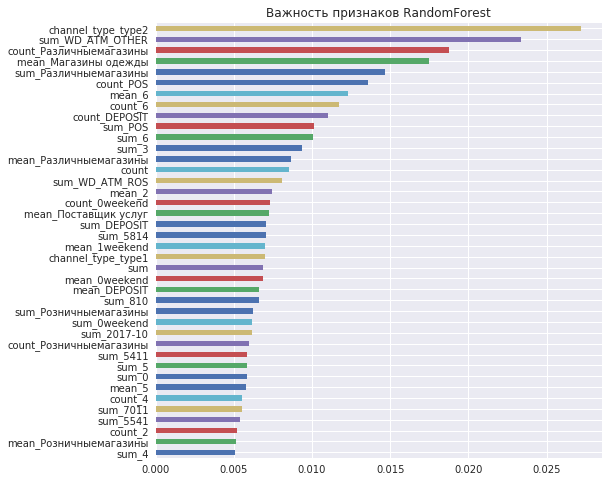

In [233]:
imp = pd.Series(select_rf_pipe.named_steps['select'].estimator_.feature_importances_, index=X_train.columns)
imp.sort_values(ascending=False).head(40)[::-1].plot(kind='barh', title='Важность признаков RandomForest',  figsize=(8,8))

In [234]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectFromModel(LogisticRegression(penalty='l1')))
])


lasso_pipe.fit(X_train, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None))])

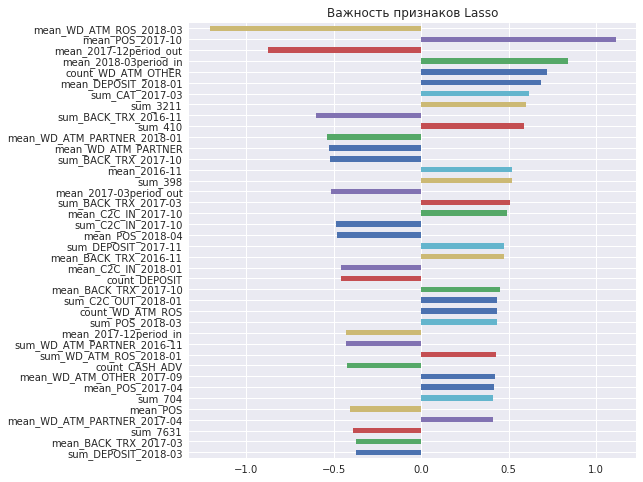

In [235]:
imp_lasso = pd.Series(lasso_pipe.named_steps['select'].estimator_.coef_[0], index=X_train.columns)
imp_lasso = imp_lasso.reindex(imp_lasso.abs().sort_values(ascending=False).index)
imp_lasso.head(40)[::-1].plot(kind='barh', title='Важность признаков Lasso',  figsize=(8,8))

## Модели

In [236]:
clf_line1 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])


clf_line2 = Pipeline([
    ('scaler', StandardScaler()),
    ('select', PCA(0.99)),
    ('clf', LogisticRegression())
])

clf_line3 = Pipeline([
    ('scaler', StandardScaler()),
#    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', LogisticRegression())
])

clf_line4 = Pipeline([
    ('scaler', StandardScaler()),
#    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('clf', LogisticRegression())
])




#cross_val_score(clf_line1, X_train_l, y_train_l, cv=5, scoring='roc_auc')


In [237]:
print('Линейная модель:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_line1, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейная модель:
roc_auc на cv: 0.7033574264148604


In [238]:
print('Линейная модель c PCA:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_line2, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейная модель c PCA:
roc_auc на cv: 0.7083419766034608


In [239]:
print('Линейная модель c PCA и отбором признаков:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_line3, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейная модель c PCA и отбором признаков:
roc_auc на cv: 0.7593784937426278


In [240]:
print('Линейная модель c PCA и отбором признаков:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_line4, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейная модель c PCA и отбором признаков:
roc_auc на cv: 0.7069782270021179


In [242]:
clf_svc1 = Pipeline([
    ('scaler', StandardScaler()),
#    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', LinearSVC())
])

clf_svc2 = Pipeline([
    ('scaler', StandardScaler()),
#    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', SVC(kernel='rbf'))
])

clf_svc3 = Pipeline([
    ('scaler', StandardScaler()),
#    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', SVC(kernel='poly'))
])


clf_svc4 = Pipeline([
    ('scaler', StandardScaler()),
#    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('clf', LinearSVC())
])


In [243]:
print('Линейный SVC:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_svc1, X_train, y, cv=5, scoring='roc_auc').mean()))

Линейный SVC:
roc_auc на cv: 0.7557782956868412


In [244]:
print('Нелинейный SVC:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_svc2, X_train, y, cv=5, scoring='roc_auc').mean()))

Нелинейный SVC:
roc_auc на cv: 0.7652815162522237


In [189]:
print('Нелинейный SVC:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_svc3, X_train, y, cv=5, scoring='roc_auc').mean()))

Нелинейный SVC:
roc_auc на cv: 0.7277766298279056


In [245]:
print('Нелинейный SVC:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_svc4, X_train, y, cv=5, scoring='roc_auc').mean()))

Нелинейный SVC:
roc_auc на cv: 0.7028787326377943


In [249]:
clf_rf1 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier())
])


clf_rf2 = Pipeline([
    ('scaler', StandardScaler()),
    ('select', PCA(0.99)),
    ('clf', RandomForestClassifier())
])

clf_rf3 = Pipeline([
    ('scaler', StandardScaler()),
    ('select1', PCA(0.99)),
    ('select2', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('clf', RandomForestClassifier())
])

In [247]:
print('Случайный лес:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_rf1, X_train, y, cv=5, scoring='roc_auc').mean()))

Случайный лес:
roc_auc на cv: 0.748750923918324


In [124]:
print('Случайный лес с PCA:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_rf2, X_train, y, cv=5, scoring='roc_auc').mean()))

Случайный лес с PCA:
roc_auc на cv: 0.6216510860792349


In [250]:
print('Случайный лес с PCA и отбором признаков:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_rf3, X_train, y, cv=5, scoring='roc_auc').mean()))

Случайный лес с PCA и отбором признаков:
roc_auc на cv: 0.6242366663768177


In [203]:

clf_knn = Pipeline([
    ('scaler', StandardScaler()),
#    ('select', PCA(0.80)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', KNeighborsClassifier(n_neighbors=4))
])

clf_rf = Pipeline([
    ('scaler', StandardScaler()),
#    ('select', PCA(0.99)),
    ('select2', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED))
])

clf_svc = Pipeline([
    ('scaler', StandardScaler()),
#    ('select', PCA(0.99)),
    ('select2', SelectFromModel(estimator=RandomForestClassifier())),
    ('clf', LinearSVC())
])



lr = LogisticRegression(penalty='l1')

np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf_knn, clf_rf, clf_svc], meta_classifier=lr)

print('5-fold cross validation:\n')

for clf, label in zip([clf_knn, clf_rf, clf_svc, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'SVC',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train.values, y.values, cv=3, scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))


5-fold cross validation:

Accuracy: 0.66 (+/- 0.06) [KNN]
Accuracy: 0.75 (+/- 0.07) [Random Forest]
Accuracy: 0.77 (+/- 0.09) [SVC]
Accuracy: 0.72 (+/- 0.08) [StackingClassifier]


In [128]:
from sklearn.ensemble import GradientBoostingClassifier

In [212]:
clf_gb1 = Pipeline([
    ('scaler', StandardScaler()),
#    ('select', PCA(0.99)),
#    ('select2', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('clf', GradientBoostingClassifier(n_estimators=1000, random_state=RANDOM_SEED ))
])



In [213]:
print('GB с PCA :')
print('roc_auc на cv: {}'.format(cross_val_score(clf_gb1, X_train, y, cv=3, scoring='roc_auc', n_jobs=-1).mean()))

GB с PCA :
roc_auc на cv: 0.793508996375068


In [295]:
clf_xgb1 = Pipeline([
#    ('scaler', StandardScaler()),
#    ('select', PCA(0.99)),
#    ('select2', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('clf', XGBClassifier(n_estimators=100, reg_alpha=0.001, min_child_weight=10, random_state=RANDOM_SEED, max_depth=3, learning_rate=0.06, subsample=0.8, colsample_bytree=0.8))
])

In [296]:
%%time
print('XGB:')
print('roc_auc на cv: {}'.format(cross_val_score(clf_xgb1, X_train, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()))

XGB:
roc_auc на cv: 0.8244194144895293
CPU times: user 1.47 s, sys: 204 ms, total: 1.67 s
Wall time: 52.6 s


### XGBOOST

In [301]:
def find_params(clf, param_grid, scoring='roc_auc', n_iter=50, fit_params={}):
    clf_grid = RandomizedSearchCV(
        clf, 
        param_distributions=param_grid, 
        cv=10, 
        n_jobs=-1, 
        scoring=scoring, 
        random_state=42, 
        n_iter=n_iter, 
#        fit_params = fit_params
#        verbose=3
    )
    clf_grid.fit(X_train, y, **fit_params)
#    best_prep_params = clf_grid.best_estimator_.named_steps['prep'].get_params()
    best_params = clf_grid.best_estimator_.named_steps['clf'].get_params()
    best_score = clf_grid.best_score_
#    msle_scores[clf_grid.best_estimator_.named_steps['reg'].__class__.__name__] = -clf_grid.score(X_test, y_test)
    print(clf_grid.best_estimator_.named_steps['clf'].__class__.__name__)
#    print('Best prep params: {}'.format(best_prep_params))
    print('Best params: {}'.format(best_params))
    print('roc_auc на cv: {}'.format(best_score))
    return clf_grid.best_estimator_.named_steps['clf'], best_params

In [302]:
xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('clf', XGBClassifier(random_state=42))
])
xgb_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'clf__n_estimators': [100],
    'clf__learning_rate': uniform(loc=0.05, scale=0.5),
    'clf__colsample_bytree': uniform(loc=0.1, scale=0.9),
    'clf__max_depth': randint(low=1, high=10),
    'clf__min_child_weight': randint(low=5, high=20),
    'clf__subsample': uniform(loc=0.1, scale=0.9),
}
best_estimator, best_params = find_params(xgb_pipe, xgb_params, 'roc_auc', 50)

XGBClassifier
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.22554447458683766, 'gamma': 0, 'learning_rate': 0.19607232426760907, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 16, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.5628109945722505}
roc_auc на cv: 0.8330438612625699


## Предсказание

Лучшей моделью с параметрами по умолчанию оказался нелинейный SVM с ядром RBF. Точность можно было бы улучшить настройкой параметров на GridSearch. Времени на это не осталось. Делаем предсказание, как есть.

In [262]:
clf_xgb1.fit(X_train, y)

Pipeline(memory=None,
     steps=[('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=2, min_child_weight=10, missing=None, n_estimators=1200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))])

In [263]:
y_pred = []
y_pred

[]

In [264]:
y_pred = clf_xgb1.predict(X_pred)

/home/max/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [265]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [266]:
y_pred = pd.Series(y_pred, index=X_pred.index)

In [267]:
y_pred.value_counts()

1    2741
0    2476
dtype: int64

In [268]:
y_pred.to_csv('predictions.csv', sep=',', header=True, index_label=['_ID_', '_VAL_'])

# WOE признак для MCC

In [44]:
df.sample(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend,is_withdrawal
497040,2017-05,817,6011,type2,810,2017-05-06,5000.00,WD_ATM_OTHER,0,Поставщик услуг,RUB,1.0,1.0,5000.00,5,1,False
70306,2016-12,5274,5732,type1,810,2016-12-08,190.00,POS,1,Различныемагазины,RUB,1.0,1.0,190.00,3,0,True
13152,2016-11,5761,5499,type1,810,2016-11-06,258.00,POS,0,Розничныемагазины,RUB,1.0,1.0,258.00,6,1,True
479698,2017-05,1790,5814,type2,810,2017-05-01,346.00,POS,1,Различныемагазины,RUB,1.0,1.0,346.00,0,0,True
836600,2017-08,3733,5411,type1,810,2017-08-11,513.62,POS,1,Розничныемагазины,RUB,1.0,1.0,513.62,4,0,True


In [45]:
df_train = df[df['is_test']==0]
df_test = df[df['is_test']==1]
df_train = df_train.join(y, how='left', on='cl_id')
print(df_train.shape)
print(df_test.shape)

(490513, 18)
(518376, 17)


In [46]:
df_train.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
PERIOD,490513,19,2017-07,55757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cl_id,490513,NaN,NaN,NaN,NaN,NaN,4802.13,2986.49,0,2193,4576,7390,10215
MCC,490513,344,5411,121640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_type,490513,6,type1,299247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
currency,490513,59,810,477644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRDATETIME,490513,58113,2017-06-23 00:00:00,1971,2016-10-07 00:00:00,2018-04-02 23:20:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,490513,NaN,NaN,NaN,NaN,NaN,5723.59,77037.6,0.04,224,624,2176,3.5835e+07
trx_category,490513,10,POS,416425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_test,490513,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
MCC_group,490513,21,Розничныемагазины,178436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


построим WOE для категориального признака MCC, у которого 344 уникальных значений

In [47]:
df_train[['MCC','target_flag']].sample(5)

,MCC,target_flag
211806,5541,1
263928,6011,0
728122,5814,1
126487,8999,0
318292,5411,1


In [74]:
df_woe = pd.DataFrame(index=df_train['MCC'].unique())

In [75]:
df_woe['number_good'] = df_train[df_train['target_flag']==1].groupby(['MCC'])['MCC'].agg('count')
df_woe['number_bad'] = df_train[df_train['target_flag']==0].groupby(['MCC'])['MCC'].agg('count')

In [76]:
df_woe.head()

,number_good,number_bad
5411,75343.0,46297.0
6011,35524.0,18858.0
4121,4876.0,1390.0
6012,5709.0,4347.0
8999,1522.0,1077.0


In [77]:
df_woe['dist_good'] = df_woe['number_good'] / df_woe['number_good'].sum(axis=0)
df_woe['dist_bad'] = df_woe['number_bad'] / df_woe['number_bad'].sum(axis=0)

In [78]:
df_woe.head()

,number_good,number_bad,dist_good,dist_bad
5411,75343.0,46297.0,0.235371,0.271680
6011,35524.0,18858.0,0.110977,0.110663
4121,4876.0,1390.0,0.015233,0.008157
6012,5709.0,4347.0,0.017835,0.025509
8999,1522.0,1077.0,0.004755,0.006320


In [79]:
df_woe['WoE'] = np.log(df_woe['dist_good'] / df_woe['dist_bad'])

In [80]:
df_woe.head()

,number_good,number_bad,dist_good,dist_bad,WoE
5411,75343.0,46297.0,0.235371,0.271680,-0.143462
6011,35524.0,18858.0,0.110977,0.110663,0.002836
4121,4876.0,1390.0,0.015233,0.008157,0.624586
6012,5709.0,4347.0,0.017835,0.025509,-0.357878
8999,1522.0,1077.0,0.004755,0.006320,-0.284590


In [81]:
df_woe['IV'] = (df_woe['dist_good'] - df_woe['dist_bad']) * df_woe['WoE']

In [82]:
df_woe.head()

,number_good,number_bad,dist_good,dist_bad,WoE,IV
5411,75343.0,46297.0,0.235371,0.271680,-0.143462,5.208943e-03
6011,35524.0,18858.0,0.110977,0.110663,0.002836,8.911698e-07
4121,4876.0,1390.0,0.015233,0.008157,0.624586,4.419444e-03
6012,5709.0,4347.0,0.017835,0.025509,-0.357878,2.746418e-03
8999,1522.0,1077.0,0.004755,0.006320,-0.284590,4.454773e-04


In [83]:
df_woe['IV'].sum()

0.07218063242722546

С таким значением IV признак MCC является слабым предиктором и можно вообще исключить из рассмотрения..

Если признак являлся бы предиктором выше среднего, то вместо категорий можно использовать значения WoE

In [86]:
df_train = df_train.join(df_woe['WoE'] , how='left', on='MCC')
df_test = df_test.join(df_woe['WoE'] , how='left', on='MCC')

In [85]:
df_train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,is_test,MCC_group,curr_code,exch_rate,exch_nominal,amount_rub,dayofweek,is_weekend,is_withdrawal,target_flag,WoE
0,2016-10,1290,5411,type2,810,2016-10-07 00:00:00,2465.0,POS,0,Розничныемагазины,RUB,1.0,1.0,2465.0,4,0,True,1,-0.143462
3,2016-10,485,6011,type2,810,2016-10-07 00:00:00,3600.0,WD_ATM_PARTNER,0,Поставщик услуг,RUB,1.0,1.0,3600.0,4,0,True,1,0.002836
4,2016-10,485,4121,type2,810,2016-10-07 00:00:00,242.0,POS,0,Транспорт,RUB,1.0,1.0,242.0,4,0,True,1,0.624586
10,2016-10,1290,6011,type2,810,2016-10-07 18:57:17,10000.0,WD_ATM_ROS,0,Поставщик услуг,RUB,1.0,1.0,10000.0,4,0,False,1,0.002836
11,2016-10,8119,5411,type1,810,2016-10-08 00:00:00,597.0,POS,0,Розничныемагазины,RUB,1.0,1.0,597.0,5,1,True,1,-0.143462
